# Robust Query Processing for Linked Data Fragements
<a id='overview'></a>

# Evaluation Notebook - Overview

In this Notebook, we provide the evalautions presented in "Robust Query Processing for Linked Data Fragments".
Overview
  
## [CROP Evaluation](#crop_evaluation)

- [Cost Model Parameters](#cost_model_parameter)
- [IDP Parameter](#idp_parameter)
- [Planner Parameter](#planner_parameter)
- [Custom Benchmark](#custom_benchmark)
- [Comparison to the State of the Art](#comparison_sota)

## [Polymorphic Operator Evaluation](#poly_evaluation)

- [Overview Table](#poly_overview_table)
- [Improvement - Degradation Plots](#poly_imp_deg_plots)
- [Diefficiency Plots](#poly_dief_plots)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import linregress, pearsonr
import yaml
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc
from matplotlib import transforms
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import json
from ast import literal_eval

# Color Scheme
config_file = "notebook_config.yaml"
nb_config = yaml.load(open(config_file).read())
my_colors = nb_config['style']['colors']
barplot_colors = [my_colors['my_light_gray'], my_colors['my_yellow'], my_colors['my_light_blue'], my_colors['my_green']]


barplot_blues = ["#EFF1F2", "#B8CFD7", "#81ADBC", "#4A8BA0","#146985"]
nlde_bm2_query_suffix = {
    "MU" : "Music",
    "SP" : "Sports",
    "MO" : "Movies",
    "LS" : "LifeScience",
    "HI" : "Historical"
} 
plt.rcParams.update(nb_config['style']['rcParams'])

plt.rc('text.latex', preamble=r'\usepackage{mathrsfs}') 

def sum_div_3(values):
    return sum(values) / 3

def percentage(values):
    return int(np.mean(values) * 100)

In [2]:
# Stats of query answers
answers_nlde_bm1 = {
    "Q01" : 2, "Q02" : 8, "Q03" : 18, "Q04" : 54, "Q05" : 1091, "Q06" : 188, "Q07" : 251, "Q08" : 17807, "Q09" : 5223, "Q10" : 9040,
    "Q11" : 9481, "Q12" : 11002, "Q13" : 24325, "Q14" : 26570, "Q15" : 26757, "Q16" : 30589, "Q17" : 33485, "Q18" : 45655205, "Q19" : 64, "Q20" : 1688
}
answers_nlde_bm2 = {
    "HIQ1" : 2, "HIQ2" : 2, "HIQ3" : 4, "HIQ4" : 170, "HIQ5" : 138,
    "LSQ1" : 4, "LSQ2" : 6, "LSQ3" : 7, "LSQ4" : 8, "LSQ5" : 270,
    "MOQ1" : 15, "MOQ2" : 46, "MOQ3" : 49, "MOQ4" : 56, "MOQ5" : 87,
    "MUQ1" : 7, "MUQ2" : 63, "MUQ3" : 68, "MUQ4" : 114, "MUQ5" : 1768,
    "SPQ1" : 4, "SPQ2" : 12, "SPQ3" : 14, "SPQ4" : 19, "SPQ5" : 36,
}

watdiv_f = {'F11': 0, 'F12': 9, 'F13': 5, 'F14': 4, 'F15': 9,
 'F21': 0, 'F22': 0, 'F23': 7, 'F24': 8, 'F25': 7, 
 'F31': 26, 'F32': 5, 'F33': 26, 'F34': 5, 'F35': 5,
 'F41': 20, 'F42': 44, 'F43': 4, 'F44': 44, 'F45': 4,
 'F51': 25, 'F52': 25, 'F53': 38, 'F54': 58, 'F55': 25 }
watdiv_l =  { 'L11': 2, 'L12': 0, 'L13': 2, 'L14': 0, 'L15': 1,
 'L21': 15, 'L22': 15, 'L23': 48, 'L24': 48, 'L25': 236,
 'L31': 38, 'L32': 41, 'L33': 21, 'L34': 27, 'L35': 41,
 'L41': 54, 'L42': 60, 'L43': 47, 'L44': 57, 'L45': 47,
 'L51': 239, 'L52': 66, 'L53': 239, 'L54': 66, 'L55': 76 }
watdiv_s =  {'S11': 19, 'S12': 9, 'S13': 9, 'S14': 9, 'S15': 9,
 'S21': 11, 'S22': 14, 'S23': 12, 'S24': 17, 'S25': 11,
 'S31': 0, 'S32': 0, 'S33': 320, 'S34': 0, 'S35': 0,
 'S41': 0, 'S42': 4, 'S43': 1, 'S44': 1, 'S45': 0,
 'S51': 0, 'S52': 9, 'S53': 0, 'S54': 9, 'S55': 9,
 'S61': 1, 'S62': 1, 'S63': 2, 'S64': 1, 'S65': 2,
 'S71': 5, 'S72': 2, 'S73': 1, 'S74': 13, 'S75': 7 }
watdiv_c =  {'XC11': 20, 'XC21': 2, 'XC31': 417029}

print (f"nLDE BM 1: Min: {np.min(list(answers_nlde_bm1.values()))}; Median: {np.median(list(answers_nlde_bm1.values()))}; Max {np.max(list(answers_nlde_bm1.values()))}")
print (f"nLDE BM 2: Min: {np.min(list(answers_nlde_bm2.values()))}; Median: {np.median(list(answers_nlde_bm2.values()))}; Max {np.max(list(answers_nlde_bm2.values()))}")

print (f"WatDiv C: Min: {np.min(list(watdiv_c.values()))}; Median: {np.median(list(watdiv_c.values()))}; Max {np.max(list(watdiv_c.values()))}")
print (f"WatDiv F: Min: {np.min(list(watdiv_f.values()))}; Median: {np.median(list(watdiv_f.values()))}; Max {np.max(list(watdiv_f.values()))}")
print (f"WatDiv L: Min: {np.min(list(watdiv_l.values()))}; Median: {np.median(list(watdiv_l.values()))}; Max {np.max(list(watdiv_l.values()))}")
print (f"WatDiv S: Min: {np.min(list(watdiv_s.values()))}; Median: {np.median(list(watdiv_s.values()))}; Max {np.max(list(watdiv_s.values()))}")

nLDE BM 1: Min: 2; Median: 7131.5; Max 45655205
nLDE BM 2: Min: 2; Median: 19.0; Max 1768
WatDiv C: Min: 2; Median: 20.0; Max 417029
WatDiv F: Min: 0; Median: 8.0; Max 58
WatDiv L: Min: 0; Median: 47.0; Max 239
WatDiv S: Min: 0; Median: 4.0; Max 320


<a id='crop_evaluation'></a>
# CROP - Evaluation


<a id='cost_model_parameter'></a>
## Cost-Model: Height Discount Paramater $\delta$ 

[Back to overview](#overview)

In [3]:
df_delta = pd.read_csv("../experimental_results/01_height_discount_delta.csv")
benchmark_df ={}
for benchmark in ["WatDiv", "nLDE"]:
    data_list= []
    df_sel = df_delta[df_delta['dataset'].str.startswith(benchmark)]
    for i in range(0,8):
        corr_df = df_sel[df_sel['delta'] == i]
        pbj_sum = sum(corr_df['BJ_count'])
        phj_sum = sum(corr_df['HJ_count'])
        bushy_avg = np.mean(corr_df['bushy_plan'])
        pbj_ratio = pbj_sum / (pbj_sum + phj_sum)

        data_list.append({
            "height discount" : i,
            "Runtime (s)" : round(corr_df['runtime_s'].sum() / 3, 2),
            "Requests" : int(corr_df['requests'].sum() / 3),
            "Bind Joins" : int(round(pbj_ratio*100, 2)),
            "Bushy Plans" : int(round(bushy_avg*100, 2)),
        })
    table_df = pd.DataFrame(data_list)
    benchmark_df[benchmark] = table_df

table_df = pd.merge(benchmark_df["WatDiv"], benchmark_df["nLDE"], how='left', on=['height discount'], suffixes=[" watdiv", " nLDE"])
table_df.index = table_df['height discount']
table_df.drop(columns=['height discount'], inplace=True)
table_df

,Runtime (s) watdiv,Requests watdiv,Bind Joins watdiv,Bushy Plans watdiv,Runtime (s) nLDE,Requests nLDE,Bind Joins nLDE,Bushy Plans nLDE
height discount,,,,,,,,
0,255.00,24039,50,2,1300.65,24702,34,10
1,267.01,30133,61,2,588.74,24743,39,10
2,224.60,30708,66,0,330.99,27184,44,10
3,222.15,29907,72,0,221.27,36154,54,10
4,221.26,29587,74,0,182.86,36497,59,10
5,236.55,32933,74,2,196.83,40082,67,5
6,215.22,32659,73,5,200.95,42587,71,5
7,211.72,32651,74,5,202.02,42586,71,5


<a id='idp_parameter'></a>
## IDP: Block size k

[Back to overview](#overview)

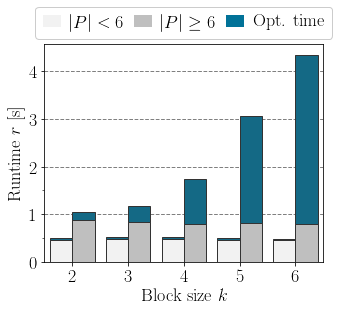

In [4]:
df_k = pd.read_csv("../experimental_results/02_idp_block_size_k.csv")

df_02 = df_k
df_02['benchmark'] = df_02['benchmark'].apply(lambda x : "WatDiv" if "WatDiv" in x else "nLDE") 
df_02['tp_6'] = False
df_02.loc[df_02['triple_pattern_count'] >= 6, 'tp_6'] = True

params = {'legend.fontsize': 18,
          'legend.handlelength': 2}
plt.rcParams.update(params)
fig=plt.figure(figsize=(5, 4))
bplot1 = sns.barplot(x="idp_k", y="runtime_s",ci=None, data=df_02, estimator=np.median, palette=[my_colors['my_blue'], my_colors['my_blue']], edgecolor=".2", hue="tp_6")
bplot1.set_label("_nolegend_")

bplot = sns.barplot(x="idp_k", y="execution_time_s",ci=None, estimator=np.median, data=df_02, palette=[my_colors['my_lightest_gray'], my_colors['my_light_gray']], linewidth=1, edgecolor=".2",hue="tp_6", alpha=1)
bplot1.legend().remove()

plt.xlabel("Block size $k$", fontsize=18)
plt.ylabel("Runtime $r$ [s]", fontsize=18)

opt_patch = mpatches.Patch(label=r'Opt. time', edgecolor='black', lw=.0, facecolor=my_colors['my_blue'])
gray_patch = mpatches.Patch(label=r'$|P| < 6$', edgecolor='black', lw=.0, facecolor=my_colors['my_lightest_gray'])
hatch_patch = mpatches.Rectangle(xy=(1,1), width=2, height=2,label='$|P| \geq 6$', hatch="",facecolor=my_colors['my_light_gray'],
                                   edgecolor='black', lw=.0, alpha=.99)
vals = [0, 0.5, 1.0, 1.5, 2.0]
bplot1.set_yticks(vals, [str(val) for val in vals])
bplot.set_axisbelow(True)
bplot.yaxis.grid(color='gray', linestyle='dashed', linewidth=1) 
plt.tick_params(labelsize=18)
plt.legend(loc='center', ncol=3, bbox_to_anchor=(0.5, 1.1), handles=[gray_patch, hatch_patch, opt_patch], fancybox=True, framealpha=1.0, fontsize=18, columnspacing=0.5, handlelength=1, handletextpad=0.5)

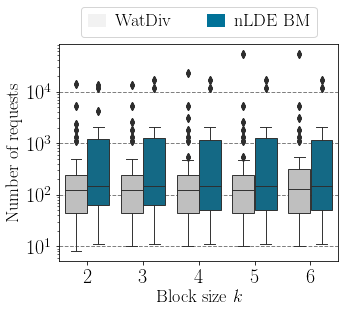

In [5]:
params = {'legend.fontsize': 18,
          'legend.handlelength': 2}
plt.rcParams.update(params)
fig=plt.figure(figsize=(5, 4))

bplot = sns.boxplot(x="idp_k", y="requests", data=df_02, hue="benchmark", hue_order=["WatDiv", "nLDE"],  palette=[my_colors['my_light_gray'], my_colors['my_blue']], linewidth=0.95 )#, saturation=1) #ci=None,


plt.xlabel("Block size $k$", fontsize=18)
plt.ylabel("Number of requests", fontsize=18)


watdiv_patch = mpatches.Patch(label='WatDiv', edgecolor='black', lw=.0, facecolor=my_colors['my_lightest_gray'])
nlde_patch = mpatches.Patch(label='nLDE BM', edgecolor='black', lw=.0, facecolor=my_colors['my_blue'])

plt.legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.1), columnspacing=2, handlelength=1, handletextpad=0.5, fontsize=18, handles=[watdiv_patch, nlde_patch])
plt.tick_params(labelsize=20)
plt.yscale("log")
bplot.set_axisbelow(True)
bplot.yaxis.grid(color='gray', linestyle='dashed', linewidth=1) 

[Text(0, 0, 'WatDiv'), Text(0, 0, 'nLDE BM')]

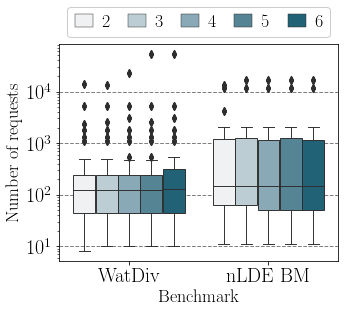

In [6]:
params = {'legend.fontsize': 18,
          'legend.handlelength': 2}
plt.rcParams.update(params)
fig=plt.figure(figsize=(5, 4))

bplot = sns.boxplot(x="benchmark", y="requests", data=df_02, hue="idp_k",   palette=barplot_blues, linewidth=0.95, order=["WatDiv", "nLDE"] )#, saturation=1) #ci=None,


plt.ylabel("Number of requests", fontsize=18)
plt.xlabel("Benchmark", fontsize=18)
plt.legend(loc='center', ncol=5, bbox_to_anchor=(0.5, 1.1), fancybox=True, framealpha=1.0, fontsize=18, columnspacing=1, handlelength=1, handletextpad=0.5)
plt.tick_params(labelsize=20)
plt.yscale("log")
bplot.set_axisbelow(True)
bplot.yaxis.grid(color='gray', linestyle='dashed', linewidth=1) 
bplot.set_xticklabels( ["WatDiv", "nLDE BM"], size = 20, rotation=0)

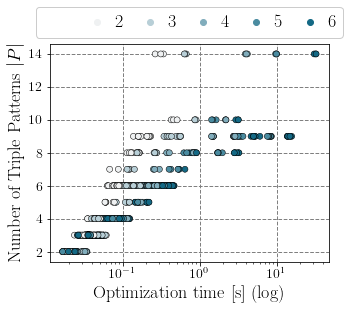

In [7]:
params = {'legend.fontsize': 18,
          'legend.handlelength': 2}
plt.rcParams.update(params)
fig=plt.figure(figsize=(5, 4))

bplot = sns.scatterplot(x='optimization_time_s', y='triple_pattern_count', hue="idp_k", data=df_02, palette=barplot_blues, edgecolor='black', linewidth=0.5)
bplot.legend(title="")
plt.xscale("log")
plt.tick_params(labelsize=14)
plt.xlabel("Optimization time [s] (log)", fontsize=18)
plt.ylabel("Number of Triple Patterns $|P|$", fontsize=18)
lgnd = plt.legend(title="", loc='center', ncol=6, bbox_to_anchor=(0.5, 1.1), fancybox=True, framealpha=1.0, fontsize=18, columnspacing=1, handlelength=1, handletextpad=0.5)
lgnd.texts[0].set_text("")

bplot.set_axisbelow(True)
bplot.yaxis.grid(color='gray', linestyle='dashed', linewidth=1) 
bplot.xaxis.grid(color='gray', linestyle='dashed', linewidth=1) 

<a id='planner_parameter'></a>
## Query Planner: Cost and robustnes threshold $\gamma$ and $\rho$

[Back to overview](#overview)

In [8]:
df_03 = pd.read_csv("../experimental_results/03_planner_thresholds.csv")
df_03['benchmark'] = df_03['benchmark'].apply(lambda x : "WatDiv" if "WatDiv" in x else "nLDE") 
benchmark = "nLDE"
table_1 = pd.pivot_table(index=["cost_threshold"], columns=["robustness_threshold"], 
                                       values=['r_star_selected', 'requests','runtime_s'], aggfunc=np.sum, 
                                       data=df_03[df_03['benchmark'] == benchmark],fill_value=0).div(3) # Divide by 3, since 3 runs

sorted_columns = [ (col_name, r)  for r  in [0.05,0.10,0.15,0.20,0.25] for col_name in ["runtime_s", "requests","r_star_selected"]]
table_1 = table_1[sorted_columns]
table_1

,runtime_s,requests,r_star_selected,runtime_s,requests,r_star_selected,runtime_s,requests,r_star_selected,runtime_s,requests,r_star_selected,runtime_s,requests,r_star_selected
robustness_threshold,0.05,0.05,0.05,0.10,0.10,0.10,0.15,0.15,0.15,0.20,0.20,0.20,0.25,0.25,0.25
cost_threshold,,,,,,,,,,,,,,,
0.1,291.446594,31465.0,1.0,303.136549,49925.0,2.0,303.954220,49925.0,2.0,304.311724,49925.0,2.0,384.134367,58092.0,3.0
0.3,293.189948,31465.0,1.0,303.294151,49925.0,2.0,301.459074,49925.0,2.0,299.854754,49925.0,2.0,302.199882,49925.0,2.0
0.5,290.028678,31465.0,1.0,196.185857,35783.0,1.0,196.008764,35783.0,1.0,196.815586,35783.0,1.0,195.370298,35783.0,1.0
0.7,290.838492,31465.0,1.0,196.666559,35783.0,1.0,196.276996,35783.0,1.0,198.504252,35783.0,1.0,196.258338,35783.0,1.0
0.9,289.723112,31465.0,1.0,195.779244,35783.0,1.0,197.665910,35783.0,1.0,196.062558,35783.0,1.0,197.126103,35783.0,1.0


In [9]:
benchmark = "WatDiv"
table_1 = pd.pivot_table(index=["cost_threshold"], columns=["robustness_threshold"], 
                                       values=['r_star_selected', 'requests','runtime_s'], aggfunc=np.sum, 
                                       data=df_03[df_03['benchmark'] == benchmark],fill_value=0).div(3) # Divide by 3, since 3 runs

sorted_columns = [ (col_name, r)  for r  in [0.05,0.10,0.15,0.20,0.25] for col_name in ["runtime_s", "requests","r_star_selected"]]
table_1 = table_1[sorted_columns]
table_1

,runtime_s,requests,r_star_selected,runtime_s,requests,r_star_selected,runtime_s,requests,r_star_selected,runtime_s,requests,r_star_selected,runtime_s,requests,r_star_selected
robustness_threshold,0.05,0.05,0.05,0.10,0.10,0.10,0.15,0.15,0.15,0.20,0.20,0.20,0.25,0.25,0.25
cost_threshold,,,,,,,,,,,,,,,
0.1,87.875307,20796.0,6.0,89.043317,20796.0,6.0,96.466978,21504.0,6.0,97.306087,21643.0,6.0,338.298703,26395.0,8.0
0.3,87.788720,20796.0,6.0,89.676069,20796.0,6.0,194.621905,30078.0,2.0,196.183034,30217.0,2.0,196.445318,30217.0,2.0
0.5,195.144526,30078.0,2.0,195.152095,30078.0,2.0,196.769549,30078.0,2.0,197.626256,30217.0,2.0,197.453008,30217.0,2.0
0.7,194.413121,30078.0,2.0,193.609525,30078.0,2.0,196.467227,30078.0,2.0,194.966556,30085.0,0.0,195.292924,30085.0,0.0
0.9,195.191127,30078.0,2.0,192.968016,30078.0,2.0,194.842096,30078.0,2.0,195.765510,30085.0,0.0,194.485165,30085.0,0.0


<a id='custom_benchmark'></a>
## Custom Benchmark

[Back to overview](#overview)

In [10]:
metric2label = {
    "runtime_s" : "Runtime $s$ (log)",
    "requests" : "Number of requests (log)",
    "answers" : "Number of answers (log)",
    "robustness_plan" : "$robustness(P^*)$",
} 
df_04 = pd.read_csv("../experimental_results/04_custom_benchmark.csv")
df_04['robustness_plan'] = df_04['bc_cost_p_star'] / df_04['ac_cost_p_star']

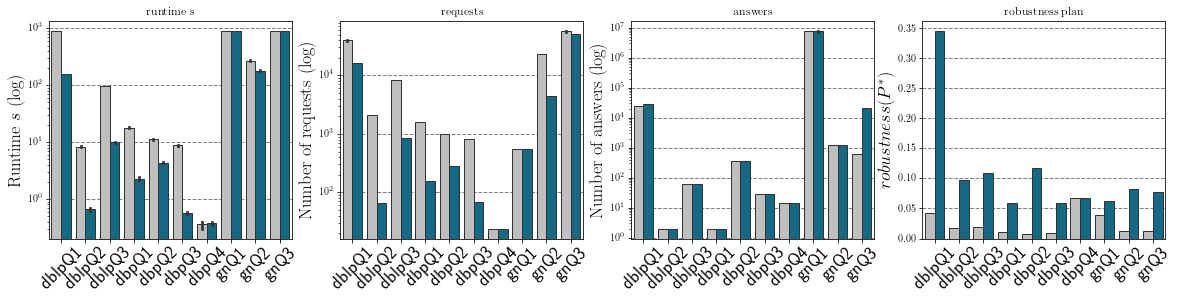

In [11]:
params = {'legend.fontsize': 18,
          'legend.handlelength': 2}
plt.rcParams.update(params)

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for metric, axis in zip(metric2label.keys(), axes):

    bplot = sns.barplot(ax=axis, x="query", y=metric, hue="robustness_threshold", data=df_04, palette=[my_colors['my_light_gray'],my_colors['my_blue']],
                       linewidth=1, errcolor=".2", edgecolor=".2",hue_order=[0.00, 0.05], alpha=1)

    bplot.set_ylabel(metric2label[metric], fontsize=18,labelpad=3)
    bplot.set_xlabel("")

    lgnd = bplot.legend(loc='center', ncol=5, bbox_to_anchor=(0.5, 1.1), fancybox=True, framealpha=1.0, fontsize=18, columnspacing=1, handlelength=1, handletextpad=0.5)
    lgnd.get_texts()[0].set_text('$\\rho = 0.00$')
    lgnd.get_texts()[1].set_text('$\\rho = 0.05$')
    lgnd.texts[0].set_text("")
    lgnd.remove()
    
    bplot.set_title(metric.replace("_", " "))
    
    bplot.set_axisbelow(True)
    bplot.yaxis.grid(color='gray', linestyle='dashed', linewidth=1) 

    bplot.set_xticklabels( [f"\\textsf{{{query.get_text()}}}" for query in bplot.get_xticklabels()], size = 18, rotation=45)

    if metric in ["requests", "runtime_s", "answers", "bc_cost_p_star"]:
        bplot.set_yscale("log")

<a id='comparison_sota'></a>
## Comparison to the State of the Art

[Back to overview](#overview)

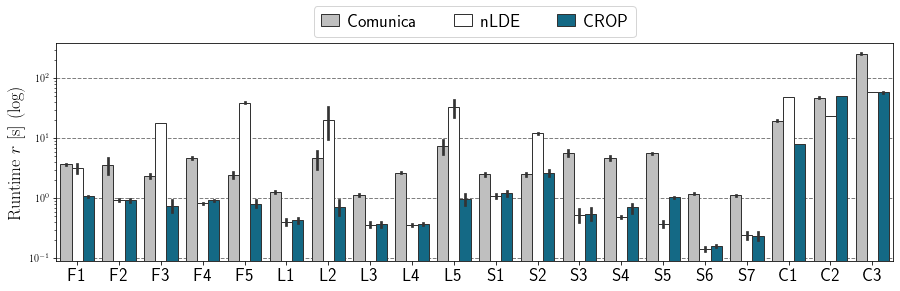

In [12]:
metric = "runtime_s"
benchmark = "WatDiv"
df_sota = pd.read_csv("../experimental_results/05_comparison_to_sota.csv")
df_plot = df_sota[df_sota['benchmark'] == benchmark]
df_plot['querytype'] = df_plot['query'].apply(lambda x : x.replace("X", "")[:2] )

params = {
    'legend.fontsize': 14,
    'legend.handlelength': 2}
plt.rcParams.update(params)
fig=plt.figure(figsize=(15, 4))


colors_bp = [my_colors['my_light_gray'], "w", my_colors['my_blue']]

bplot = sns.barplot(x="querytype", y=metric, hue="client", data=df_plot, palette=colors_bp,
                   linewidth=1, errcolor=".2", edgecolor=".2", hue_order=["comunica", "nlde", "crop"])
    
bplot.set_xlabel("", fontsize=1)
if metric == "runtime_s":
    bplot.set_ylabel("Runtime $r$ [s] (log)", fontsize=18)
    
if metric == "requests":
    bplot.set_ylabel("Number of Requests (log)", fontsize=18)
    
bplot.set_yscale("log")
bplot.set_xticklabels( [f"\\textsf{{{querytype.get_text()}}}" for querytype in bplot.get_xticklabels()], size = 18, rotation=0)

handles, labels = bplot.get_legend_handles_labels()
bplot.legend(loc='center', ncol=3, bbox_to_anchor=(0.5, 1.1), columnspacing=2, handlelength=1, handletextpad=0.5, fontsize=18,fancybox=True, handles=handles, labels=[r"\textsf{Comunica}", r"\textsf{nLDE}", r"\textsf{CROP}"])

bplot.set_axisbelow(True)
bplot.yaxis.grid(color='gray', linestyle='dashed', linewidth=1) 

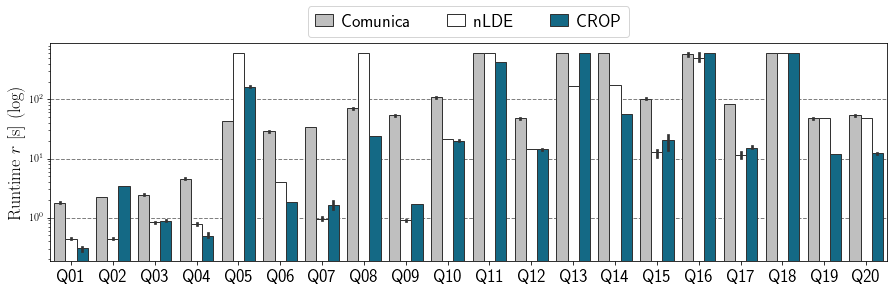

In [13]:
metric = "runtime_s"
benchmark = "nLDE BM1"
df_plot = df_sota[df_sota['benchmark'] == benchmark]

params = {
    'legend.fontsize': 14,
    'legend.handlelength': 2}
plt.rcParams.update(params)
fig=plt.figure(figsize=(15, 4))


colors_bp = [my_colors['my_light_gray'], "w", my_colors['my_blue']]

bplot = sns.barplot(x="query", y=metric, hue="client", data=df_plot, palette=colors_bp,
                   linewidth=1, errcolor=".2", edgecolor=".2", hue_order=["comunica", "nlde", "crop"])
    
bplot.set_xlabel("", fontsize=1)
if metric == "runtime_s":
    bplot.set_ylabel("Runtime $r$ [s] (log)", fontsize=18)
    
if metric == "requests":
    bplot.set_ylabel("Number of Requests (log)", fontsize=18)
    
bplot.set_yscale("log")
bplot.set_xticklabels( [f"\\textsf{{{querytype.get_text()}}}" for querytype in bplot.get_xticklabels()], size = 18, rotation=0)

handles, labels = bplot.get_legend_handles_labels()
bplot.legend(loc='center', ncol=3, bbox_to_anchor=(0.5, 1.1), columnspacing=2, handlelength=1, handletextpad=0.5, fontsize=18,fancybox=True, handles=handles, labels=[r"\textsf{Comunica}", r"\textsf{nLDE}", r"\textsf{CROP}"])

bplot.set_axisbelow(True)
bplot.yaxis.grid(color='gray', linestyle='dashed', linewidth=1) 

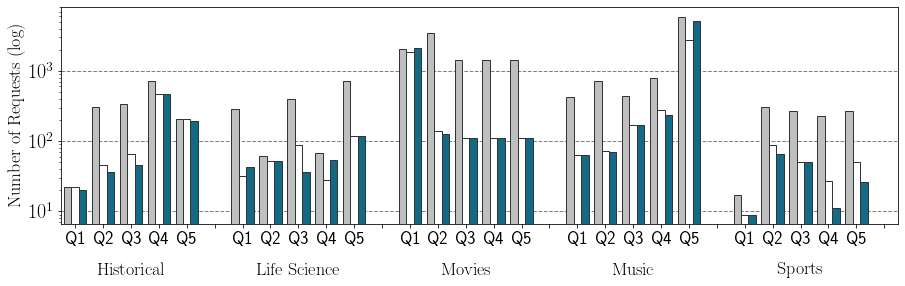

In [14]:
metric = "requests"
benchmark = "nLDE BM2"

df_plot = df_sota[df_sota['benchmark'] == benchmark]

query_order = ["HIQ1", "HIQ2", "HIQ3", "HIQ4", "HIQ5", "", 
               "LSQ1", "LSQ2", "LSQ3", "LSQ4", "LSQ5", "",
               "MOQ1", "MOQ2", "MOQ3", "MOQ4", "MOQ5", "", 
               "MUQ1", "MUQ2", "MUQ3", "MUQ4", "MUQ5", "", 
               "SPQ1", "SPQ2", "SPQ3", "SPQ4", "SPQ5", ""]


params = {
    'legend.fontsize': 14,
    'legend.handlelength': 2}

plt.rcParams.update(params)
fig=plt.figure(figsize=(15, 4))
colors_bp = [my_colors['my_light_gray'], "w", my_colors['my_blue']]

bplot = sns.barplot(x="query", y=metric, hue="client", data=df_plot, palette=colors_bp, order=query_order,
                   linewidth=1, errcolor=".2", edgecolor=".2", hue_order=["comunica", "nlde", "crop"])

query_pos = np.sort( [p.get_x() + p.get_width()/2  for p in bplot.patches])

plt.tick_params(labelsize=20)
plt.xlabel("", fontsize=1)
if metric == "runtime_s":
    plt.ylabel("Runtime $r$ [s] (log)", fontsize=18)
    
if metric == "requests":
    plt.ylabel("Number of Requests (log)", fontsize=18)
    
plt.yscale("log")
#bplot.set_xticklabels([f"\\textsf{{{query_label}}}" for query_label in query_labels], size = 18, rotation=0)
bplot.set_xticklabels([f"\\textsf{{{querytype.get_text()[2:]}}}" for querytype in bplot.get_xticklabels()], size = 18, rotation=0)

labels = ["Historical", "Life Science", "Movies", "Music", "Sports"]

group_pos = query_pos.reshape(-1, 6*3).mean(axis=1)
trans = transforms.blended_transform_factory(bplot.transData, bplot.transAxes)

for pos, label in zip(group_pos, labels):
    bplot.text(pos-0.5, -0.25,  label, transform=trans, ha='center', va='bottom', fontsize=18)

handles, labels = bplot.get_legend_handles_labels()
lgnd = plt.legend(loc='center', ncol=3, bbox_to_anchor=(0.5, 1.1), columnspacing=2, handlelength=1, handletextpad=0.5, fontsize=18,fancybox=True, handles=handles, labels=[r"\textsf{Comunica}", r"\textsf{nLDE}", r"\textsf{CROP}"])
lgnd.remove()

bplot.set_axisbelow(True)
bplot.yaxis.grid(color='gray', linestyle='dashed', linewidth=1) 

In [15]:
def percentage(values):
    return 100 * np.mean(values)

def sum_div_3(values):
    return np.sum(values) / 3

df_table = df_sota
df_table['benchmark'] = df_table['benchmark'].apply(lambda x : "WatDiv" if "WatDiv" in x else "nLDE") 
overview_table = df_table.groupby(['benchmark','client'])[['runtime_s','requests', 'answers', 'timeout_reached']].agg([np.mean, np.median, sum_div_3, percentage])

cols = [
    ("runtime_s", "mean"),
    ("runtime_s", "median"),
    ("requests", "mean"),
    ("answers", "sum_div_3"),
    ("timeout_reached", "percentage")
]
overview_table = overview_table[cols]
overview_table

runtime_s               requests       answers  \
                         mean    median         mean     sum_div_3   
benchmark client                                                     
WatDiv    comunica   6.983587  2.762500  1572.011364  4.194480e+05   
          crop       2.123511  0.677058   375.750000  4.194480e+05   
          nlde       9.005790  0.842211   862.670455  4.194480e+05   
nLDE      comunica  84.284481  4.670000  9234.348148  4.239040e+05   
          crop      58.140472  0.892247  4520.251852  2.969457e+06   
          nlde      77.149660  0.773837  3897.148148  6.616570e+06   

                   timeout_reached  
                        percentage  
benchmark client                    
WatDiv    comunica        0.000000  
          crop            0.000000  
          nlde            0.000000  
nLDE      comunica       10.370370  
          crop            6.666667  
          nlde            9.629630

<a id='poly_evaluation'></a>
# Polymorphic Join Operators

[Back to overview](#overview)

<a id='poly_overview_table'></a>
## Overview Table

[Back to overview](#overview)

In [16]:
df_poly = pd.read_csv("../experimental_results/06_pjo_experimental_results.csv")
df_poly['hash_join_only'].fillna(False, inplace=True)
df_poly['bind_join_only'].fillna(False, inplace=True)

In [17]:
df_table = df_poly
df_table['benchmark'] = df_table['benchmark'].apply(lambda x : "WatDiv" if "WatDiv" in x else "nLDE") 

bm2table = {}
for benchmark in ["WatDiv", "nLDE"]:
    final_table = pd.DataFrame()
    for planner in ["ldp shj" , "ldp nlj", "ldp",  "nlde", "crop"]:
        df_agg = df_table[(df_table['benchmark'] == benchmark)
                           & (df_table['planner'] == planner)] 

        agg_cols = ["runtime_s", "answers", "requests", "switch_percentage_PBJ", "switch_percentage_PHJ", "timeout_reached"]
        df_agg = df_agg.groupby(['planner','poly_hash_join', 'poly_bind_join'])[agg_cols].agg([np.mean, np.median, sum_div_3, percentage])
        cols = [('runtime_s', "mean"), ('runtime_s', "median"), ('requests', 'mean'), ('answers', 'sum_div_3'), ("switch_percentage_PBJ", "percentage") ,  ("switch_percentage_PHJ", "percentage") ]
        table = df_agg[cols]

        final_table = pd.concat([final_table, table])
    
    
    bm2table[benchmark] = final_table
    
final_table = pd.merge(left=bm2table['WatDiv'], right=bm2table['nLDE'], left_index=True, right_on=['planner','poly_hash_join', 'poly_bind_join'], suffixes=[" WatDiv", " nLDE BM"])
final_table

runtime_s WatDiv             \
                                                  mean     median   
planner poly_hash_join poly_bind_join                               
ldp shj False          False                 37.289716  15.807935   
        True           False                 10.859580   1.844698   
ldp nlj False          False                 12.909280   2.952804   
                       True                   2.186976   0.779258   
ldp     False          False                  6.480468   1.181977   
                       True                   3.951865   1.069887   
        True           False                  4.689339   0.705941   
                       True                   2.113634   0.698524   
nlde    False          False                  9.005790   0.842211   
                       True                   6.129634   0.845001   
        True           False                  8.467418   0.855801   
                       True                   5.612523   0.854182   
crop    False          False                  2.123511   0.677058   
                       True                   1.986429   0.679609   
        True           False                  2.094911   0.641286   
                       True                   1.974094   0.649956   

                                      requests WatDiv answers WatDiv  \
                                                 mean      sum_div_3   
planner poly_hash_join poly_bind_join                                  
ldp shj False          False              1961.465909  375163.000000   
        True           False               651.125000   16202.666667   
ldp nlj False          False              1859.818182  419448.000000   
                       True                298.155303  419448.000000   
ldp     False          False               611.284091  419448.000000   
                       True                395.863636  419448.000000   
        True           False               499.007576  419448.000000   
                       True                283.662879  419448.000000   
nlde    False          False               862.670455  419448.000000   
                       True                531.159091  419448.000000   
        True           False               828.719697  419448.000000   
                       True                497.155303  419448.000000   
crop    False          False               375.750000  419448.000000   
                       True                272.647727  419448.000000   
        True           False               373.924242  419448.000000   
                       True                270.814394  419448.000000   

                                      switch_percentage_PBJ WatDiv  \
                                                        percentage   
planner poly_hash_join poly_bind_join                                
ldp shj False          False                              0.000000   
        True           False                              0.000000   
ldp nlj False          False                              0.000000   
                       True                              33.081710   
ldp     False          False                              0.000000   
                       True                               6.363636   
        True           False                              0.000000   
                       True                               6.363636   
nlde    False          False                              0.000000   
                       True                               8.901515   
        True           False                              0.000000   
                       True                               8.901515   
crop    False          False                              0.000000   
                       True                               5.000000   
        True           False                              0.000000   
                       True                               5.000000   

                          

<a id='poly_imp_deg_plots'></a>
## Improvement - Degradation Plot

[Back to overview](#overview)

In [18]:
def to_id(row):
    
    if row['poly_hash_join'] and row['poly_bind_join']:
        return 2
    
    elif row['poly_hash_join']:
        return 3
    
    elif row['poly_bind_join']:
        return 5
    
    else:
        return 6
    

df_poly['config_id'] = df_poly.apply(to_id, axis=1)

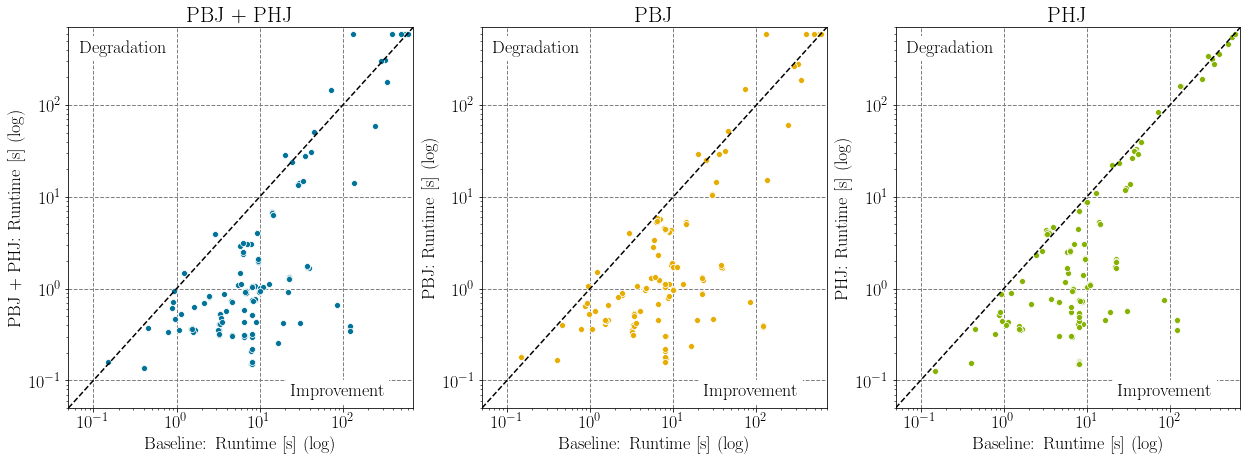

In [19]:
df_piv = df_poly.pivot_table(index="query", columns=['config_id'], values="runtime_s", aggfunc=np.mean)
max_overall = 700 

params = {'legend.fontsize': 12,
          'legend.handlelength': 1}
plt.rcParams.update(params)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

fig, axes = plt.subplots(1, 3, figsize=(21, 7))


baseline = 6
for axis, compare in zip(axes, [2, 5, 3]):

    sel_color = {
    2 : my_colors['my_blue'],
    3 : my_colors['my_green'],
    5 : my_colors['my_dark_orange']}[compare]
    
    y_label = {
    2 : "PBJ + PHJ",
    3 : "PHJ",
    5 : "PBJ",
    6 : "Baseline",
    }[compare]
    
    bplot = sns.scatterplot(x=df_piv[baseline], y=df_piv[compare], color=sel_color, ax=axis)
    
    bplot.set_yscale("log")
    bplot.set_xscale("log")
    bplot.set_ylim([0.05,max_overall])
    bplot.set_xlim([0.05,max_overall])
    bplot.plot([0, 1], [0, 1], transform=bplot.transAxes, color='k',linestyle="--")
    #bplot.axline((0, 0), slope=1, color='k',linestyle="--" )

    bplot.set_axisbelow(True)
    bplot.yaxis.grid(color='gray', linestyle='dashed', linewidth=1) 
    bplot.xaxis.grid(color='gray', linestyle='dashed', linewidth=1)

    bplot.set_xlabel(r"Baseline: Runtime [s] (log)", fontsize=18)
    bplot.set_ylabel(f"{y_label}: Runtime [s] (log) ", fontsize=18)
    bplot.text(0.03, 0.934, "Degradation", fontsize=18, transform=bplot.transAxes, backgroundcolor="white")
    bplot.text(0.642, 0.03, "Improvement", fontsize=18, transform=bplot.transAxes , backgroundcolor="white")
    
    bplot.set_title(y_label, fontsize=22)


<a id='poly_dief_plots'></a>
## Diefficiency Plots

[Back to overview](#overview)

Note: This is just an example plot for a single query. The answer traces for the remaining queries of the evaluation are contained in the `zip` file. 

Text(0, 0.5, 'Number of answers')

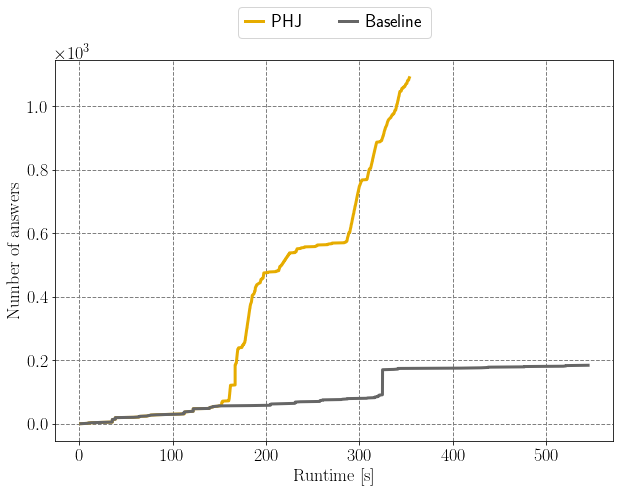

In [20]:
df_dief = pd.read_csv(f"../experimental_results/07_diefficiency/ldp_shj_Q05.tsv", sep="\t")

config_id_1 = 3
config_id_2 = 6  

params = {'legend.fontsize': 12,
          'legend.handlelength': 1}
plt.rcParams.update(params)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plot_1 = df_dief[(df_dief['config_id'] == config_id_1)]
plot_2 = df_dief[(df_dief['config_id'] == config_id_2)]

fig=plt.figure(figsize=(10, 7))

poly_color = my_colors['my_green'] if config_id_1 != 3 else my_colors['my_dark_orange']

plot = sns.lineplot(plot_1["delta_s"], plot_1["counter"], color=poly_color, linestyle="solid", linewidth=3, label="PHJ") # ['my_green']
plot = sns.lineplot(plot_2["delta_s"], plot_2["counter"], color=my_colors['my_gray'], linestyle="dotted", linewidth=3, label="Baseline")

handles, labels = plot.get_legend_handles_labels()
plt.legend(loc='center', ncol=3, bbox_to_anchor=(0.5, 1.1), columnspacing=2, handlelength=1, handletextpad=0.5, fontsize=18, handles=handles[0:], labels=[f"\\textsf{{{lab}}}" for lab in labels[0:]])


plot.set_axisbelow(True)
plot.yaxis.grid(color='gray', linestyle='dashed', linewidth=1) 
plot.xaxis.grid(color='gray', linestyle='dashed', linewidth=1)

#plt.xscale("log")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel("Runtime [s]", fontsize=18)
plt.ylabel("Number of answers", fontsize=18)